# Differentiable Spatial to Numerical Transform (DSNT)

A dummy implementation of DSNT layer from the paper "Numerical Coordinate Regression with Convolutional Neural Networks" by Aiden Nibali, Zhen He, Stuart Morgan, Luke Prendergast. Link: https://arxiv.org/abs/1801.07372

- Main references: https://github.com/ashwhall/dsnt/blob/master/DSNT_example.ipynb

In [2]:
import tensorflow as tf
import numpy as np
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

# Data Generation 

In [3]:
img_size = 150
image_count = 200 #number of images 
train_percent = 0.75
train_image_count = int(train_percent * image_count)
test_image_count = image_count - train_image_count

images = []
targets = [] #centroid coordinates of circle 
for _ in range(200):
    img = np.zeros((img_size, img_size, 3))
    row, col = np.random.randint(0, img_size), np.random.randint(0, img_size)
    radius = np.random.randint(8, 15)
    b, g, r = np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)
    cv2.circle(img, (row, col), radius, (b, g, r), -1)
    images.append(img)
    norm_row = row / img_size
    norm_col = col / img_size
    targets.append([norm_row, norm_col])

images = np.array(images, dtype = 'float32')
#normalize image:
images = images/255.0
targets = np.array(targets, dtype = 'float32')
train_images = images[:train_image_count]
test_images = images[train_image_count:]
train_targets = targets[:train_image_count]
test_targets = targets[train_image_count:]

print('''
{} images total
training: {}
testing : {}'''.format(image_count, train_image_count, test_image_count))


200 images total
training: 150
testing : 50


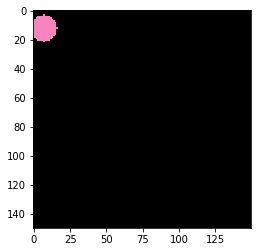

In [4]:
#visualize image:
for i in range(len(images)):
    plt.imshow(images[i])
    plt.show()
    break
    
#     if input()=="exit":
#         break

# Model 

By using dilated convolutional layers, each time downsampling by a factor of 2. The network finishes with a kernel-size 1 convolution, producing a single channel heat-map.

In [5]:
from tensorflow.keras import Model, Sequential 
from tensorflow.keras.layers import Conv2D, ReLU, Dense, Flatten 
from tensorflow.keras.layers import MaxPooling2D
import dsnt #https://github.com/ashwhall/dsnt/blob/master/dsnt.py

#to do Coordconv implementation
class model(Model):
    def __init__(self):
        super(model, self).__init__()
        self.inference_net = Sequential([
            tf.keras.layers.InputLayer(input_shape=(150, 150, 3)),
            Conv2D(filters = 166, kernel_size = 3, strides = 1, 
                    padding = "same", dilation_rate = 1,  
                   activation = 'relu'), 
            MaxPooling2D(pool_size = 2, strides = 2, padding = 'same'),

            Conv2D(filters = 32, kernel_size = 3, strides = 1, 
                    padding = "same", dilation_rate = 2,  
                   activation = 'relu'), 
            MaxPooling2D(pool_size = 2, strides = 2, padding = 'same'),

            Conv2D(filters = 64, kernel_size = 3, strides = 1, 
                    padding = "same", dilation_rate = 4,  
                   activation = 'relu'), 
            MaxPooling2D(pool_size = 2, strides = 2, padding = 'same'),

            Conv2D(filters = 128, kernel_size = 3, strides = 1, 
                    padding = "same", dilation_rate = 8,  
                   activation = 'relu'), 
            MaxPooling2D(pool_size = 2, strides = 2, padding = 'same'),

            Conv2D(filters = 256, kernel_size = 3, strides = 1, 
                    padding = "same", dilation_rate = 16,  
                   activation = 'relu'), 
            MaxPooling2D(pool_size = 2, strides = 2, padding = 'same'),

            Conv2D(filters = 256, kernel_size = 3, strides = 1, 
                    padding = "same", dilation_rate = 1,  
                   activation = 'relu'), 
            MaxPooling2D(pool_size = 2, strides = 2, padding = 'same'),

            Conv2D(filters = 1, kernel_size = 1, strides = 1, 
                    padding = "same"),  
        ])
    
    def output(self, inp):
        inference = self.inference_net(inp)
        norm_heatmap, coords = dsnt.dsnt(inference)
        
        return norm_heatmap, coords

In [6]:
BATCH_SIZE = 32
MAX_STEP = 5000
lr = 6e-5

model = model()

ds_train = tf.data.Dataset.from_tensor_slices((train_images, train_targets)).shuffle(10000).repeat(100).batch(BATCH_SIZE)

In [7]:
for layer in model.layers:
    print(layer.output)

Tensor("conv2d_6/BiasAdd:0", shape=(None, 3, 3, 1), dtype=float32)


In [8]:
opt = tf.keras.optimizers.Adam(lr)
mse = tf.keras.losses.MeanSquaredError()

def loss_fn(model, imgs, lbls):
    heatmaps, predictions = model.output(imgs)
    #coordinate regression loss
    #loss_1 = tf.reduce_mean(tf.square(lbls - predictions))
    loss_1 = mse(lbls, predictions)
    #Regularization loss
    loss_2 = dsnt.js_reg_loss(heatmaps, lbls)
    Loss_total = loss_1 + loss_2
    
    return Loss_total, heatmaps, predictions
    
@tf.function
def train_fn(imgs, lbls):
    with tf.GradientTape() as tape:
        loss, heatmaps, predictions = loss_fn(model, imgs, lbls)        
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, heatmaps, predictions

loss_list = []
heatmaps_list = []
predictions_list = []
img_list = []
lbl_list = []
for steps, (img_batch, lbl_batch) in enumerate(ds_train):
    if steps > MAX_STEP:
        print('End of steps!')
        break

    loss, heatmaps, predictions = train_fn(img_batch, lbl_batch)
    
    Template = 'Step: {}, Loss: {}'

    if not steps % 100:
        loss_list.append(loss)
        heatmaps_list.append(heatmaps)
        predictions_list.append(predictions)
        img_list.append(img_batch)
        lbl_list.append(lbl_batch)
        
        print(Template.format(steps, loss))

Step: 0, Loss: 0.6986120939254761
Step: 100, Loss: 0.2570840120315552
Step: 200, Loss: 0.21254737675189972
Step: 300, Loss: 0.19615352153778076
Step: 400, Loss: 0.1734514683485031


---------------------------------

# Appendix

In [17]:
sums = 0

for value in loss_list:
    sums += value
print(sums/ image_count)

tf.Tensor(0.0076892423, shape=(), dtype=float32)


In [9]:
tmp = np.asarray(predictions_list)

In [10]:
tmp[0]

array([[ 1.11699104e-04, -1.82457268e-04],
       [-4.26173210e-06, -3.97115946e-05],
       [ 1.14336610e-04,  2.11223960e-05],
       [-6.90519810e-05, -2.26743519e-04],
       [-1.15737319e-04, -1.62012875e-04],
       [-7.90581107e-05, -8.05333257e-05],
       [-1.17033720e-04, -2.57655978e-04],
       [ 1.01372600e-04, -4.64767218e-05],
       [-1.28597021e-05, -1.68591738e-04],
       [ 6.78673387e-05, -7.15255737e-07],
       [-1.19879842e-04, -1.46284699e-04],
       [-2.11447477e-05, -2.17579305e-04],
       [ 3.07187438e-05, -1.76355243e-05],
       [ 9.04574990e-05,  1.89542770e-05],
       [-1.84997916e-05, -5.68479300e-05],
       [ 1.84774399e-05, -3.46004963e-05],
       [-6.61611557e-06,  9.80198383e-05],
       [-1.13099813e-05, -1.62303448e-04],
       [ 5.28991222e-06, -1.62377954e-04],
       [-5.16772270e-05, -1.71676278e-04],
       [-1.24782324e-04, -2.35438347e-05],
       [-6.99982047e-05, -1.26332045e-04],
       [-2.49207020e-04, -3.00273299e-04],
       [ 1.

In [11]:
tmp = np.asarray(heatmaps_list)

In [12]:
tmp_array= tmp[0]

In [13]:
tmp_array[0]

array([[0.11102127, 0.11127149, 0.11119885],
       [0.11105724, 0.11113539, 0.11109786],
       [0.11110848, 0.1110516 , 0.11105783]], dtype=float32)